#### This tutorial introduces how to use the code to: 
1. produce noise map (or cube by clipping emission regions)
2. measure noise ACF (or ACF cube) from noise map (or cube)
* ACF fully characterize noise statistical properties in interferometric images
3. (from the measured noise ACF) compute noise in the spatially integrated flux or spectrum with given aperture mask.
4. (from the measured noise ACF) simulate noise maps. 
5. (from the measured noise ACF) construct covariance matrix and formal chi-sq or likelihood expression for the problem fitting 2d model to 2d interferometric image, which is also applicable to 3d cube fitting. 

In [3]:
import os
import sys
import matplotlib.pyplot as plt
import astropy.units as u
from spectral_cube import SpectralCube
import numpy as np
from astropy.io import fits
import time
import functools
from scipy import signal
from astropy.stats import sigma_clip
from scipy import ndimage
import scipy
from astropy.modeling import models, fitting
from scipy.optimize import least_squares
from tqdm import tqdm

In [4]:
# import all the functions in essence.py
from essence.essence import*
# You can check all the details of the function by hitting, for example, help(mk_noisemap)

## 0. load your data as a spectral cube class

Please download the example data below (ADS/JAO.ALMA2017.1.00394.S PI=Gonzalez Lopez, Jorg)
https://drive.google.com/file/d/1h0wEPHVebVSjl803r9LnQyBTxfoU2kBY/view?usp=sharing, then unzip and place it in the same directory of this file.  

The below code reads ALMA 2d images and a 3d cubes as a SpectralCube object.
The SpectralCube object is useful because it retains header information and allows us to extract spatial and spectral axes.

In [5]:
# Here read band_7 continuum first to use its peak position as the image center 
path='./'
band7_cont = SpectralCube.read(path+'cont_robust0.0.image.pbcor.fits')
cy=np.where(band7_cont._data[0, :, :]==np.nanmax(band7_cont._data[0, :, :]))[0][0]
cx=np.where(band7_cont._data[0, :, :]==np.nanmax(band7_cont._data[0, :, :]))[1][0]
#And half width of the figure in [pixels].
n=25
lat_range = [cy-n,cy+n+1]
lon_range = [cx-n,cx+n+1]
# Create a sub_cube cut to these coordinates
band7_cont_s = band7_cont.subcube(xlo=lon_range[0], xhi=lon_range[1], ylo=lat_range[0], yhi=lat_range[1]
                       )#.with_spectral_unit(u.km/u.s,rest_value=oh1_freq,velocity_convention='optical')
_, b1, _ = band7_cont_s.world[0, :, 0]
_, _, l1 = band7_cont_s.world[0, 0, :]

band7 = SpectralCube.read(path+'cont_robust0.0.image.pbcor.fits') #band 7 image 
band7_s=band7.subcube(xlo=l1[0], xhi=l1[-1], ylo=b1[0], yhi=b1[-1]) #band 7 sub image 
band7_ori = SpectralCube.read(path+'cont_robust0.0.image.fits')[0] #band 7 primaly beam uncorrected
band7_pb = SpectralCube.read(path+'cont_robust0.0.pb.fits') # band 7 primaly beam 
band7_psf = SpectralCube.read(path+'cont_robust0.0.psf.fits') # band 7 psf

cii_rest=1900.53690000*u.GHz
redshift_f=4.4074#4.4069770
cii_freq=cii_rest/(redshift_f+1.)

### make all channels have common beam### 
cii_diff = SpectralCube.read(path+'CII_robust05.clean.image.pbcor.fits')
common_beam = cii_diff.beams.common_beam(auto_increase_epsilon=True, tolerance=1e-5)
cii = cii_diff.convolve_to(common_beam)

cii_diff_ori = SpectralCube.read(path+'CII_robust05.clean.image.fits')
common_beam_ori = cii_diff_ori.beams.common_beam(auto_increase_epsilon=True, tolerance=1e-5)
cii_ori = cii_diff_ori.convolve_to(common_beam_ori)

### the data already have common beam across the channel use instead ####
#cii = SpectralCube.read(path+'CII_TT_robust05.clean.image.pbcor.fits')
#cii_ori = SpectralCube.read(path+'CII_TT_robust05.clean.image.fits')

cii_vel=[-400,400]
obsdata = fits.getdata(path+'CII_robust05.clean.image.pbcor.fits')
hdu = fits.getheader(path+'CII_robust05.clean.image.pbcor.fits')
cii_pb = SpectralCube.read(path+'CII_robust05.clean.pb.fits')

cii_slab = cii.with_spectral_unit(u.km/u.s,rest_value=cii_freq,velocity_convention='radio').spectral_slab(cii_vel[0] *u.km / u.s, cii_vel[1] *u.km / u.s)
cii_ori_slab = cii_ori.with_spectral_unit(u.km/u.s,rest_value=cii_freq,velocity_convention='radio').spectral_slab(cii_vel[0] *u.km / u.s, cii_vel[1] *u.km / u.s)
cii_pb_slab = cii_pb.with_spectral_unit(u.km/u.s,rest_value=cii_freq,velocity_convention='radio').spectral_slab(cii_vel[0] *u.km / u.s, cii_vel[1] *u.km / u.s)

v_cii, _, _=cii_ori_slab.world[:, 0, 0]

cii_s=cii_slab.subcube(xlo=l1[0], xhi=l1[-1], ylo=b1[0], yhi=b1[-1])
cii_s_mom0 = cii_s.moment(order=0) # moment0 map pb corrected
cii_ori_mom0 =  cii_ori_slab.moment(order=0) # moment0 map but pb not corrected 

## 1. make noise maps or noise cube
mk_noisemap function allow you to automatically mask the 2d image or 3d cubes by
1. It masks regions where primary beam > pbfrac.  
2. It performs sigma clipping with given thresholds (default 4 sigma)  
3. The sorrounding pixels around sigma clipped regions (with the width of FWHM of the beam) are additionally masked.

In [6]:
band7_noise=mk_noisemap(band7_ori,band7_pb,pbfrac=0.5) 
cii_ori_mom0_noise=mk_noisemap(cii_ori_mom0,cii_pb,pbfrac=0.5)
cii_ori_cube_noise=mk_noisemap(cii_ori_slab,cii_pb_slab,pbfrac=0.5)

## 2. compute noise ACF
From the noise 2d map or cube, mk_acf measure the noise autocorrelation function.

In [7]:
band7_acf=mk_acf(band7_noise, 50, filename="band7") #0.87sec
cii_mom0_acf=mk_acf(cii_ori_mom0_noise, 50, filename="cii_mom0") #1.5sec
cii_cube_acf=mk_acf(cii_ori_cube_noise, 50, filename="cii_cube") #

output noise ACF array shape is  (101, 101)
file found
output noise ACF array shape is  (101, 101)
file found
output noise ACF array shape is  (41, 101, 101)
file found


protting [ 3.  7. 11. 15. 19. 23. 27.] $\sigma$


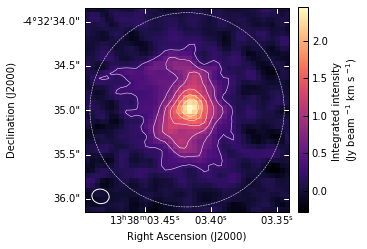

In [8]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection=cii_s_mom0.wcs)

# Display the moment map image
im = ax.imshow(cii_s_mom0.hdu.data, cmap='magma', vmax=np.max(cii_s_mom0.hdu.data))
lon, lat = ax.coords
lon.set_ticks(color='w',direction='in')
lat.set_ticks(color='w',direction='in')
#ax.tick_params(axis='y', labelrotation=45)
# Add axes labels
ax.set_xlabel('Right Ascension (J2000)')
ax.set_ylabel('Declination (J2000)')

# Add a colorbar
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('Integrated intensity \n(Jy beam $^{-1}$ km s $^{-1}$)')

from matplotlib.patches import Ellipse
from matplotlib.patches import Circle
# Overplot column density contours
levels = np.array([np.sqrt(np.max(cii_mom0_acf))*i for i in range(3,50,4)])  # Define contour levels to use
print('protting',(levels/np.sqrt(np.max(cii_mom0_acf)))[levels<np.max(cii_s_mom0.hdu.data)],'$\sigma$')
ax.contour(cii_s_mom0.hdu.data, colors='w', alpha=1, linewidths=0.5, levels=levels)
ax.add_patch(Ellipse((cii_s_mom0.header['BMAJ']*1.5/cii_s_mom0.header['CDELT2']/2.,cii_s_mom0.header['BMAJ']*1.5/cii_s_mom0.header['CDELT2']/2), width=cii_s_mom0.header['BMAJ']/cii_s_mom0.header['CDELT2'], height=cii_s_mom0.header['BMIN']/cii_s_mom0.header['CDELT2'], angle=90+cii_s_mom0.header['BPA'],edgecolor='w',facecolor='none',linewidth=1))
ax.add_patch(Circle((20.5,20.5), 20, edgecolor='w',facecolor='none',linewidth=0.5, ls='--'))
plt.savefig("./fig0.pdf", bbox_inches="tight")


## 3a. measuring noise in the spatially integrated flux
The peak value of the noise ACF corresponds to the noise variance (its square root is usually reported as rms noise in the image).

In [9]:
print(r"The rms noise of [CII] momment 0 map is", np.sqrt(np.max(cii_mom0_acf)), "Jy*(km/s)/beam")
print(r"Compare with the standard deviation of the noise map", np.nanstd(cii_ori_mom0_noise,ddof=1), "Jy*(km/s)/beam")

The rms noise of [CII] momment 0 map is 0.0872352866592822 Jy*(km/s)/beam
Compare with the standard deviation of the noise map 0.08721644693585094 Jy*(km/s)/beam


Let us now consider the variance of a sum of two random variable (noise) $N_1$ and $N_2$, each has same standard deviation $\sigma_N$ and covariance with $\mathrm{Cov}(N_1, N_2)$  
The variance of a sum of two random noise $N_1, N_2$ is   
$\sigma^2=2\times\sigma_N^2+2\times\mathrm{Cov}(N_1, N_2)$  
Similarly, the variance of a sum of three random noise $N_1, N_2, N_3$ is   
$\sigma^2=3\times\sigma_N^2+2\times\mathrm{Cov}(N_1, N_2)+2\times\mathrm{Cov}(N_2, N_3)+2\times\mathrm{Cov}(N_1, N_3)$  
Finally, the variance of a sum of $M$ random variable is  
$\sigma^2 = \mathrm{Var}(\sum_{i}N_i) = M\times\sigma_N^2+\sum_{i, j; i\neq j}\mathrm{Cov}(N_i,N_j)$  where the sum $\sum$ denotes indices $i, j$ run from 1 to $M$.  
As you see, the variance of a sum of random variables requires not only the standard deviation of individual random noise $\sigma_N$(first term) but also the covariance of every pair of random variables, which are just measured as noise ACF.  
When integrating (summing) over the pixel region of interest and deriving integrated flux, the 1sigma statistical uncertainty of the integrated flux corresponds to the square root of the variance of a sum of random noise, which we can calculate with noise ACF.

**mk_noise_var_noiseACF compute the variance of a sum of random noise over a given aperture to take sum, using noise covariance measured as a noise ACF.**

In [10]:
# make circular aperture with the radius of 20 pixel.
mask=mk_aperture(cii_s_mom0, 20)

intflux_cii=mk_intflux(mask, cii_s_mom0)/cii_s_mom0.pixels_per_beam #Jy*km/s
intflux_cii_sigma=np.sqrt(mk_noise_var_noiseACF(mask, cii_mom0_acf))/cii_s_mom0.pixels_per_beam # 1sigma noise in Jy*km/s
#The image unit is Jy*km/s/beam 
print("integrated flux of [CII] momment 0 map is "+str(intflux_cii)+" +/- "+str(intflux_cii_sigma)+" Jy*km/s")

integrated flux of [CII] momment 0 map is 29.510536736029454 +/- 1.0501853195407407 Jy*km/s


##  3b. measuring noise in the spatially integrated spectrum
Similarly mk_noise_var_noiseACF allow you to compute the noise in the integrated spectrum if you give noise ACF cube (noise ACF for each velocity channel). 

In [11]:
# measure noise in the integrated flux for each channel.
cubemask=np.array([mask for i in range(0, cii_s.shape[0])])
specrms=mk_noisespec(mask, cii_cube_acf)#np.array([np.sqrt(mk_noise_var_noiseACF(mask, cii_cube_acf[i,:,:])) for i in range(0, cii_s[:,:,:].shape[0])])

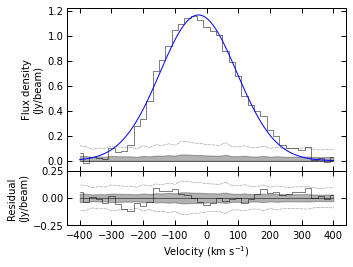

In [12]:
fig,ax=plt.subplots(2,1,figsize=(5,4),sharex=True,gridspec_kw={
                           'height_ratios': [3, 1]})
fit_g = fitting.LevMarLSQFitter()
g_init = models.Gaussian1D(amplitude=1.2, mean=0., stddev=150.,bounds={"amplitude": (0.0, 5)})
v_cii_plot=np.linspace(v_cii.value[0],v_cii.value[-1],100)
g = fit_g(g_init, v_cii.value[:], (cii_s[:,:,:]*cubemask[:,:,:]).sum(axis=1).sum(axis=1))
g = fit_g(g, v_cii.value[:], (cii_s[:,:,:]*cubemask[:,:,:]).sum(axis=1).sum(axis=1))

ax[0].plot(v_cii.value[:],(cii_s[:,:,:]*cubemask[:,:,:]).sum(axis=1).sum(axis=1),
         'k-',drawstyle='steps-mid',lw=0.5)#plot(v,flux,'k-',drawstyle='steps-mid',lw=0.5)
ax[0].plot(v_cii_plot, g(v_cii_plot),color='b')
ax[0].fill_between(v_cii.value,v_cii.value*0,v_cii.value*0+specrms,color='k',alpha=0.3)
ax[0].plot(v_cii.value,v_cii.value*0+specrms*3,'k:',lw=0.5)
ax[0].plot((v_cii.value),v_cii*0,'k',lw=0.5)
#ax[0].plot(vreg1.value, vreg1.value*0-0.3, color='k')

ax[1].plot(v_cii.value[:],(cii_s[:,:,:]*cubemask[:,:,:]).sum(axis=1).sum(axis=1)-g(v_cii.value[:]),'k-',drawstyle='steps-mid',lw=0.5)
ax[1].plot(v_cii.value,v_cii.value*0.+specrms*3,'k:',lw=0.5)
ax[1].plot(v_cii.value,v_cii.value*0.-specrms*3,'k:',lw=0.5)
ax[1].fill_between(v_cii.value,v_cii.value*0.+specrms*(-1),v_cii.value*0.+specrms,color='k',alpha=0.3)
ax[1].plot((v_cii.value),v_cii.value*0,'k',lw=0.5)
#ax[1].fill_between(v_cii,v_cii.value*0+specrms*(-1),v_cii.value*0+specrms,color='k',alpha=0.3)
ax[1].set_ylim(-0.25,0.25)
plt.xlabel('Velocity (km s$^{-1}$)')
ax[0].set_ylabel('Flux density\n(Jy/beam)')
ax[1].set_ylabel('Residual\n(Jy/beam)')
plt.subplots_adjust(hspace=0.)


## 4. simulating noise map and noise cube. 
mk_simnoises allow you to generate random noise image with the correlation properties measured by noise ACF, which is useful for Monte Carlo simulation for any image analysis.

In [13]:
snoise_band7=mk_simnoise(50, band7_acf)
snoise_cii_mom0=mk_simnoise(50, cii_mom0_acf)
snoise_cube=mk_simnoise_cube(50, cii_cube_acf)

It took 2.0735840797424316 second to generate 50x50 noise map


/home01/tsukuitk/anaconda3/envs/py37_jam/lib/python3.7/site-packages/scipy/stats/_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


It took 1.9914753437042236 second to generate 50x50 noise map
It took 86.70352435112 second to generate 41x50x50 (v, x, y) noise cube


peak do not coicide with the image center


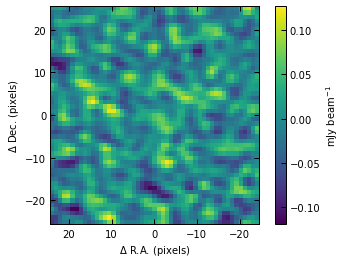

In [14]:
# Actual noise map 
Width=200
plt.imshow(zoomcen(band7_noise,Width)[100:151,150:201]*1000,extent=[25-0.5,-25+.5,-25-0.5,25+.5])
plt.xlabel(r"$\Delta$ R.A. (pixels)")
plt.ylabel(r"$\Delta$ Dec. (pixels)")
plt.colorbar(label="mJy beam$^{-1}$")
plt.savefig("./fig10a.pdf", bbox_inches="tight")

peak do not coicide with the image center
peak do not coicide with the image center


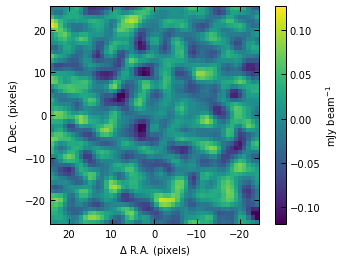

In [15]:
# Simulated noise map 
plt.imshow(snoise_band7*1000, extent=[25-0.5,-25+.5,-25-0.5,25+.5],
           vmin=(zoomcen(band7_noise,Width)[100:151,150:201]*1000).min()
           ,vmax=(zoomcen(band7_noise,Width)[100:151,150:201]*1000).max())
plt.xlabel(r"$\Delta$ R.A. (pixels)")
plt.ylabel(r"$\Delta$ Dec. (pixels)")
plt.colorbar(label="mJy beam$^{-1}$")
plt.savefig("./fig10b.pdf", bbox_inches="tight")

peak do not coicide with the image center
peak do not coicide with the image center


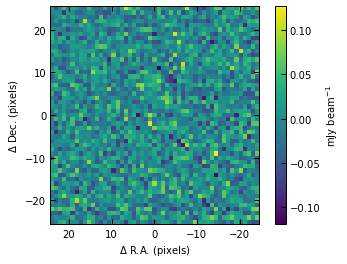

In [16]:
# Uncorrelated noise map
plt.imshow(np.random.normal(0, band7_acf.max()**0.5, 51*51).reshape(51,51)*1000,extent=[25-0.5,-25+.5,-25-0.5,25+.5],
           vmin=(zoomcen(band7_noise,Width)[100:151,150:201]*1000).min()
           ,vmax=(zoomcen(band7_noise,Width)[100:151,150:201]*1000).max())
plt.xlabel(r"$\Delta$ R.A. (pixels)")
plt.ylabel(r"$\Delta$ Dec. (pixels)")
plt.colorbar(label="mJy beam$^{-1}$")
plt.savefig("./fig10c.pdf", bbox_inches="tight")

## 5. fitting problem
Finally, we explore the effect of the noise correlation on the estimate of the statistical uncertainties of the derived model parameters.
We consider fitting a 2d gaussian model to a 2d image with the size of $N\times N$. We denote the parameters for 2d gaussian as $\theta$. When the 2d image and model are flattened to 1d vector with the size $N^2$, $I'_i$ and $I_i(\theta)$ respectively, the formal expression of the chi-square $\chi^2$ is (see e.g., Davis et al. 2017 eq. 10)  
$\chi^2=r(\theta)^{\mathrm{T}}C^{-1}r(\theta)$  **Eq.1**  
,where $C$ is covariance matrix with the size of $N^2 \times N^2$, and $r(\theta)$ is the residual vector $I'_i-I_i(\theta)$ 

If the noise in the image has no correlation, $C=\sigma_N^2E$ (E is the identity matrix), which leads to  
$\chi^2=\sum (I'_i-I_i(\theta))^2/\sigma_N^2$  **Eq.2**

mk_cov function allow you to compute $C$ covariance matrix from the measured noise ACF.
Here we compare derived posterior distributions of model parameters when (1) properly considering the noise correlation and (2) ignoring correlation and using Eq. 2 instead.

In [17]:
# lets consider gaussian fitting
from astropy.modeling import models, fitting
def Gauss2d(nx, ny, L, centx, centy, sigma_x, sigma_y, rot=0):
    """
    2d Gaussian with total luminosity (total of pixel values) of L, 
                     standard deviation of sigma_maj, sigma_min (pix)
                     position angle of rot (deg), defined as counter clock wise north to major axis
    the image size is nx times ny.
    """
    if np.tan(np.radians(rot)) == 0:
        dirfac=1
    else:
        dirfac=np.sign(np.tan(np.radians(rot)))   
    x,y=np.indices((int(nx),int(ny)),dtype='float')
    x -=centx
    y -=centy          
    a=(np.cos(np.radians(rot))**2)/(2.0*(sigma_x**2)) + (np.sin(np.radians(rot))**2)/(2.0*(sigma_y**2))
    b=((dirfac)*(np.sin(2.0*np.radians(rot))**2)/(4.0*(sigma_x**2))) + ((-1*dirfac)*(np.sin(2.0*np.radians(rot))**2)/(4.0*(sigma_y**2)))
    c=(np.sin(np.radians(rot))**2)/(2.0*(sigma_x**2)) + (np.cos(np.radians(rot))**2)/(2.0*(sigma_y**2))
    gauss=L/2./np.pi/sigma_x/sigma_y*np.exp(-1*(a*(x**2) - 2.0*b*(x*y) + c*(y**2)))
    return gauss

In [18]:
# true gaussian parameters
L=0.1
centx=10
centy=12
sigma_x=7
sigma_y=4
rot=10

# noiseless gaussian model
I=Gauss2d(25, 25, L, centx, centy, sigma_x=sigma_x, sigma_y=sigma_y, rot=rot)
# noise rms (here we use same correlated noise as band7 image)
noiserms=band7_acf.max()**0.5
# covariance matrix
cov=mk_cov(25, band7_acf, silent=False)
# the inverse of covariance matrix
invcov=scipy.linalg.pinvh(cov)

#log prior
def ln_prior(theta):
    L, centx, centy, sigma_x, sigma_y, rot = theta
    if 0.<L<0.2 and 5<centx<15 and 5<centy<15 and 5<sigma_x<15 and 0<sigma_y<10 and -10<rot<20:
        return 0.0
    return -np.inf

# log likelihood (assuming the noise is uncorrelated)
def ln_uncorr(L, centx, centy, sigma_x, sigma_y, rot):
    res=(I-Gauss2d(25, 25, L, centx, centy, sigma_x, sigma_y, rot))/noiserms
    return -0.5*(res*res).sum()

# log likelihood  (taking into account correlated noise)
def ln_corr(L, centx, centy, sigma_x, sigma_y, rot, invcov):
    res=(I-Gauss2d(25, 25, L, centx, centy, sigma_x, sigma_y, rot)).ravel() 
    return -0.5*(res @ invcov @ res)

def ln_prob_uncorr(theta):
    lp = ln_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_uncorr(*theta)

def ln_prob_corr(theta, invcov):
    lp = ln_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_corr(*theta, invcov)

initial=np.array([L, centx, centy, sigma_x, sigma_y, rot])

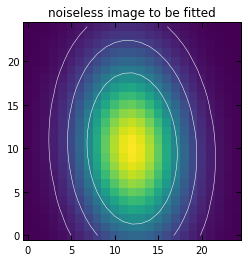

It took 0.09418749809265137 second to generate 25x25 noise map


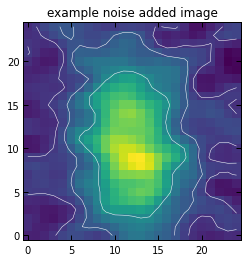

In [19]:
# show noiseless model with noise (contour 1, 3, 7 sigma)
plt.imshow(I, origin='lower')
plt.contour(I, colors='w', alpha=1, linewidths=0.5, levels=[noiserms*1, noiserms*3, noiserms*7])
plt.title('noiseless image to be fitted')
plt.show()

# correlated gaussian noise added
I_noise=I+mk_simnoise(25, band7_acf)
# show example image with noise  (contour 1, 3, 7 sigma) 
plt.imshow(I_noise, origin='lower')
plt.contour(I_noise, colors='w', alpha=1, linewidths=0.5, levels=[noiserms*1, noiserms*3, noiserms*7])
plt.title('example noise added image')
plt.show()

In [20]:
import emcee
pos = initial + 0.01*np.random.randn(32, 6) # use 32 walker for each parameters (6)
nwalkers, ndim = pos.shape

sampler_uncorr = emcee.EnsembleSampler(
    nwalkers, ndim, ln_prob_uncorr
)
sampler_uncorr.run_mcmc(pos, 5000, progress=True)

sampler_corr = emcee.EnsembleSampler(
    nwalkers, ndim, ln_prob_corr, args=([invcov])
)
sampler_corr.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [00:20<00:00, 238.14it/s]


State([[ 0.09417026 10.15646296 11.96793101  6.95100367  3.99384459 13.38828586]
 [ 0.100561    9.73477276 12.09319916  7.17242869  4.00359844  9.03661659]
 [ 0.09712982  9.69931348 11.94509412  7.05113367  3.96005114 11.04762291]
 [ 0.10007653 10.11518648 12.15244614  7.12544828  3.90202929 12.23377989]
 [ 0.09925311  9.91401379 12.01388367  7.42804303  3.75703354 14.2630109 ]
 [ 0.09552812  9.96257172 12.03797246  6.77153711  3.89380115  9.25510754]
 [ 0.10047146 10.24141396 11.80950658  7.54608979  3.98672352 11.7726989 ]
 [ 0.09642481  9.79717366 12.07617996  6.4754673   3.9112961   9.15369381]
 [ 0.10137307 10.17338871 11.97569396  7.17998479  4.05973647  7.57206754]
 [ 0.09836067 10.07649508 12.0909553   7.06500071  4.13195682 -3.75194532]
 [ 0.10150976  9.84392966 11.99509603  7.23936786  3.93468509 11.27629167]
 [ 0.09534201 10.17438728 12.10478836  7.01423062  3.98013132 12.58235322]
 [ 0.09809422  9.89405543 11.99391328  6.79057074  3.92005241  8.82568001]
 [ 0.09587841  9.95

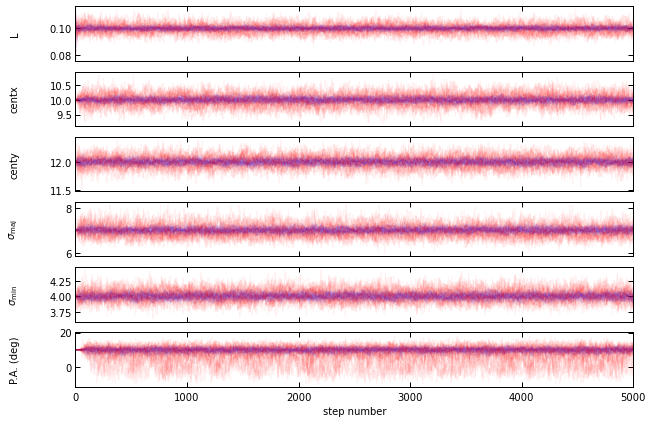

In [22]:
labels=['L', 'centx', 'centy', '$\sigma_{\mathrm{maj}}$', '$\sigma_{\mathrm{min}}$', 'P.A. (deg)']
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
samples_uncorr = sampler_uncorr.get_chain()
samples_corr = sampler_corr.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_uncorr[:, :, i], "b", alpha=0.05)
    ax.plot(samples_corr[:, :, i], "r", alpha=0.05)
    ax.set_xlim(0, len(samples_uncorr))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [23]:
print('auto-correlation time uncorr',sampler_uncorr.get_autocorr_time())
samples_uncorr = sampler_uncorr.get_chain(discard=500, thin=30, flat=True)
print('auto-correlation time corr',sampler_corr.get_autocorr_time())
samples_corr = sampler_corr.get_chain(discard=500, thin=30, flat=True)

auto-correlation time uncorr [59.75976439 65.30550522 55.99635755 63.96230141 61.29702337 61.08214258]
auto-correlation time corr [63.32518041 64.40746557 66.33630442 66.27909073 62.17862451 78.65293424]


### Compare the derived posterior distribution when ignoring noise correlation (red) and considering noise correlation with covariance matrix (blue)

[16, 50, 84]
Best fit values, Upper Error, Lower Error
[[ 0.100019  0.001124  0.001123]
 [ 9.998353  0.071292  0.068273]
 [12.001286  0.039709  0.041151]
 [ 7.000277  0.095439  0.094839]
 [ 4.002383  0.039084  0.03891 ]
 [ 9.979236  0.954873  1.112743]]


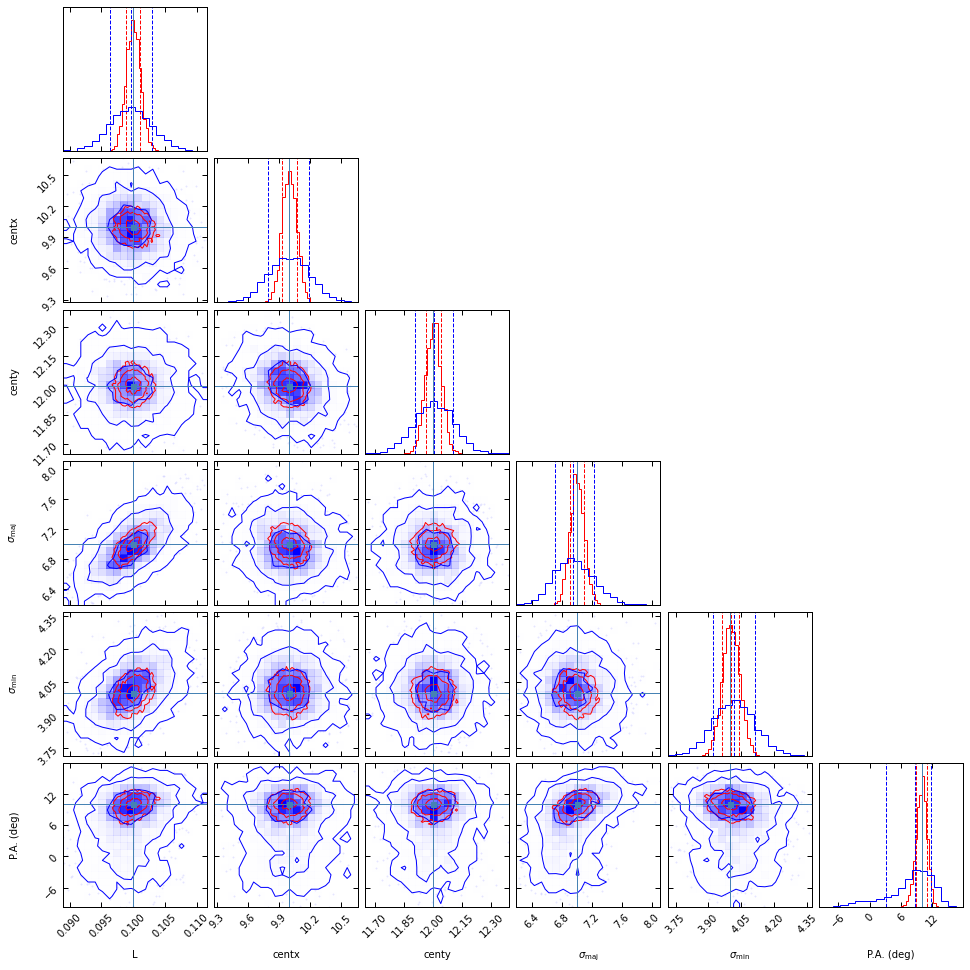

In [24]:
import corner
quantiles=np.array([0.16,0.5,0.84])
fig=corner.corner(samples_uncorr, labels=labels, quantiles=quantiles,#title_fmt=title_fmt,#truths=best, title_kwargs={'fontsize':20},label_kwargs={'fontsize':20},
              levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)),plot_datapoints=True,priors=None, color='r', truths=initial) #,truths=best[0]
corner.corner(samples_corr, fig=fig, labels=labels, quantiles=quantiles,#title_fmt=title_fmt,#truths=best, title_kwargs={'fontsize':20},label_kwargs={'fontsize':20},
              levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)),plot_datapoints=True,priors=None, color='b', truths=initial) #,truths=best[0]

#plt.savefig('../figure/1111_paper/'+'corner_plot.pdf',bbox_inches='tight', pad_inches=0.1)
mymap = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(samples_uncorr, [(quantiles[0]*100), (quantiles[1]*100), (quantiles[2]*100)],axis=0,interpolation='midpoint')))
print([int(quantiles[0]*100), int(quantiles[1]*100), int(quantiles[2]*100)]) 
bestfit=np.array(list(mymap))
print("Best fit values, Upper Error, Lower Error")
print(np.array2string(bestfit, precision=6, separator=' ',suppress_small=True))

SMALL_SIZE = 10#8 # default 10
MEDIUM_SIZE = 12 #default 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

You can see that the model uncertainty is significantly underestimated when ignoring the noise correlation.

Finally, just to be sure, we compare the MCMC posterior sampling with the result of the Monte Carlo resampling using simulated noise.
The Monte Carlo resampling is done as follows:
1. Add simulated noise to model
2. Find the best fit by fitting model 
3. Repeat 1. and 2. to find the probability density distribution of the parameters.  

In [ ]:
# Monte Carlo resampling with simulated noise from ACF
def residual(theta, I_noise):
    L, centx, centy, sigma_x, sigma_y, rot = theta
    res=I_noise-Gauss2d(25, 25, L, centx, centy, sigma_x, sigma_y, rot)
    return res.ravel()
nsamp=4000
samples_MC=np.zeros((nsamp, len(labels)))
for i in tqdm(range(0, nsamp)):
    I_noise=I+mk_simnoise(25, band7_acf, silent=True)
    samples_MC[i]=least_squares(residual, initial+0.01*np.random.randn(6), args=([I_noise])).x

In [26]:
np.save('samples_MC',samples_MC)
#samples_MC=np.load('samples_MC.npy')

### Compare the derived posterior distribution considering noise correlation with covariance matrix (blue) and that derived by Monte Carlo resampling.

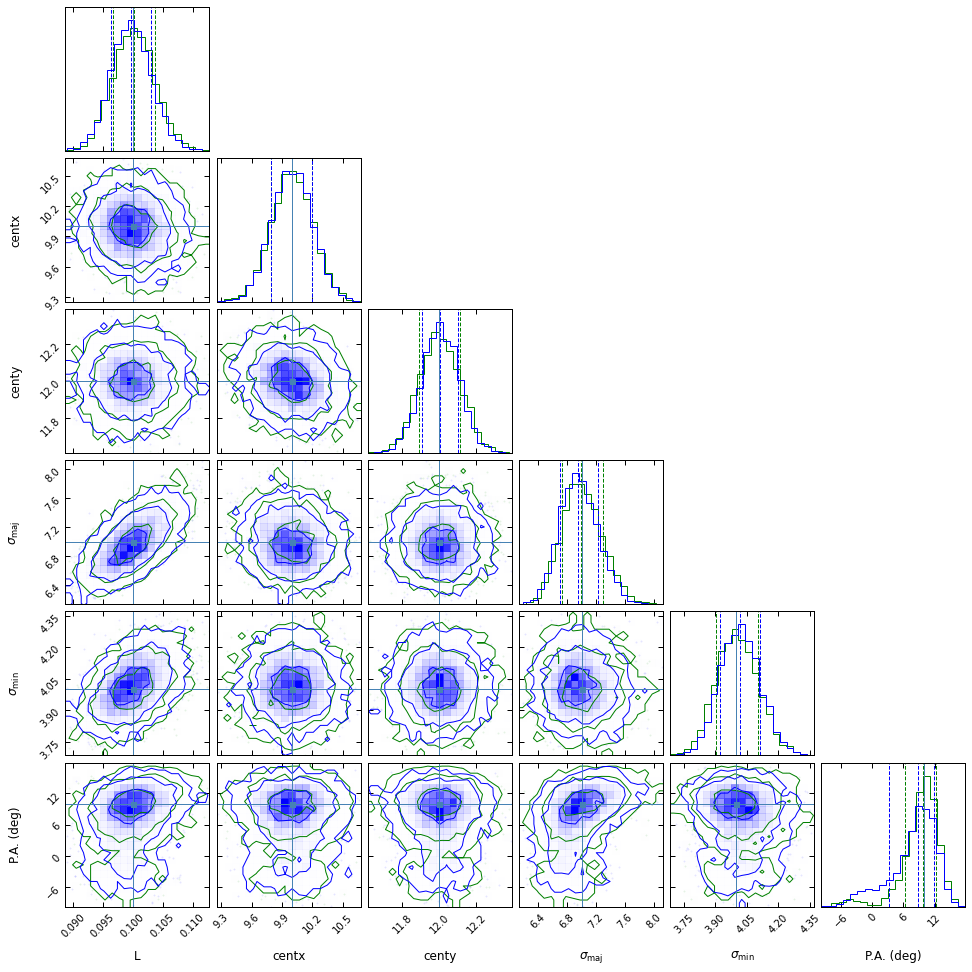

In [29]:
fig=corner.corner(samples_MC, labels=labels, quantiles=quantiles,#title_fmt=title_fmt,#truths=best, title_kwargs={'fontsize':20},label_kwargs={'fontsize':20},
              levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)),plot_datapoints=True,priors=None, color='g',truths=initial)
fig=corner.corner(samples_corr, fig=fig, labels=labels, quantiles=quantiles,#title_fmt=title_fmt,#truths=best, title_kwargs={'fontsize':20},label_kwargs={'fontsize':20},
              levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)),plot_datapoints=True,priors=None, color='b',truths=initial) #,truths=best[0]

We confirmed that the derived posterior distribution by MCMC sampling agrees with that derived by the Monte Carlo simulation using the realistic simulated noise. The Monte Carlo result shows an island in addition to the main peak, but the MCMC sampling result doesn't. MCMC sampling is not good at reproducing a sub-structure separated by a valley from the main distribution.